# 1 Setup

## 1.1 Import some great packages


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from base import ROOT_DIR
from tqdm.notebook import tqdm

## 1.2 Load the data

In [ ]:
# set paths of different subdirectories
dir_eaglebine = ROOT_DIR / 'gtx/data/Eaglebine/Eaglebine'
dir_duvernay = ROOT_DIR / 'gtx/data/Duvernay/Duvernay/'

# 2 Organize Eaglebine temperature data

## 2.1 read in BHT

In [ ]:
Eaglebine_BHT = pd.read_excel(dir_eaglebine / 'Eaglebine BHT TSC data for SPE April 21 2020.xlsx')
Eaglebine_BHT['TempC_BHT'] = (Eaglebine_BHT['BHTorMRT (maximum recorded temperature) oF'] - 32) * (5./9.)
Eaglebine_BHT.head()

In [ ]:
print("number of unique wells: " + str(len(pd.unique(Eaglebine_BHT['UWI']))))

## 2.2 Read in Eaglebine synthetic "true formation temperature"

In [ ]:
Eaglebine_Truth = pd.read_excel(dir_eaglebine / 'Eaglebine TrueTemp_Train2.xlsx')
Eaglebine_Truth.head()

In [ ]:
# convert to Celsius
Eaglebine_Truth['TempTrue_degC'] = (Eaglebine_Truth['True Temperature   (oF)'] - 32) * (5./9.)

In [ ]:
print("number of unique wells in Eaglebine in training set: " + str(len(pd.unique(Eaglebine_Truth['UWI']))))

## 2.3 Combine measured BHT and true temperature

In [ ]:
Eaglebine_Combined = Eaglebine_BHT.merge(Eaglebine_Truth, on='UWI', how='left')

In [ ]:
# only keep from the synthetic data, the temperature at the elevation closest to the model
Eaglebine_Combined['diff_depth'] = Eaglebine_Combined['Depth sub-sea (feet)']-Eaglebine_Combined['BHT_below sea level (ft)']
Eaglebine_Combined['diff_depth_abs'] = np.abs(Eaglebine_Combined['diff_depth'])
idx = Eaglebine_Combined.groupby(['UWI'])['diff_depth_abs'].transform(min) == Eaglebine_Combined['diff_depth_abs']
TrueTempUWI = Eaglebine_Combined.loc[idx, ['UWI', 'diff_depth_abs', 'TempTrue_degC']]
TrueTempUWI = TrueTempUWI.copy(deep=True)
Eaglebine_Combined_cln = Eaglebine_BHT.merge(TrueTempUWI, on='UWI', how='left')
Eaglebine_Combined_cln.head()

In [ ]:
len(Eaglebine_Combined_cln)

## 2.4 Read in static temperature information and merge into dataset

In [ ]:
Static_log_temp = pd.read_csv(ROOT_DIR / 'gtx/data/Data_static_logs.csv')
Static_log_temp.head()

In [ ]:
Eaglebine_Combined_cln['UWI'] = Eaglebine_Combined_cln['UWI'].astype(str)
Eaglebine_Combined_cln = Eaglebine_Combined_cln.copy(deep=True)
Eaglebine_Combined_cln['TrueTemp_datasource_syn'] = 'synthetic'
Static_log_temp['TrueTemp_datasource_stat'] = 'static_temp_logs'
Eaglebine_Combined_stat = Eaglebine_Combined_cln.merge(Static_log_temp, left_on='UWI',right_on='Well_ID', how='left')

In [ ]:
# Coalesce columns together with priority for true temperature measurements
Eaglebine_Combined_stat['TempC_Fin'] = Eaglebine_Combined_stat['Temp (degC)'].fillna(Eaglebine_Combined_stat['TempTrue_degC'])
Eaglebine_Combined_stat['TrueTemp_datasource'] = Eaglebine_Combined_stat['TrueTemp_datasource_stat'].fillna(Eaglebine_Combined_stat['TrueTemp_datasource_syn'])
Eaglebine_Combined_stat.head()

## 2.5 plot the eaglebine temperature data

In [ ]:
import matplotlib.pyplot as plt
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=Eaglebine_Combined_stat, x="TempC_BHT", y="TempC_Fin", hue='BHT_below sea level (ft)', ax=ax)

ax.set_xlim([30, 220])
ax.set_ylim([30, 220])
ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# 3 Organize Duvernay temperature data

## 3.1 Read in DST BHT input and "true temp" synthetic data

In [ ]:
Duvernay_Truth = pd.read_excel(dir_duvernay / 'Duvenay TrueTemp_Train.xlsx')
Duvernay_DST = pd.read_excel(dir_duvernay / 'Duvernay DST BHT for SPE April 20 2021.xlsx')
Duvernay_Truth.head()

In [ ]:
# add in an extra column calculating the depth sub sea (elevation-depth)*-1 
Duvernay_DST['Depth_SS(m)']=-1*(Duvernay_DST['elevation M above sea level']-(Duvernay_DST['DST Start Depth (MD) (m)']+Duvernay_DST['DST End Depth (MD) (m)'])/2)
Duvernay_DST.head()

In [ ]:
# merge
Duvernay_Combined = Duvernay_DST.merge(Duvernay_Truth, on='UWI', how='left')
Duvernay_Combined.head()

In [ ]:
# keep only the synthetic model temperature data for the relevant depths for which there is BHT measurement
Duvernay_Combined['diff_depth'] = Duvernay_Combined['Depth_SS(m)']-Duvernay_Combined['Depths subsea (m)']
Duvernay_Combined['diff_depth_abs'] = np.abs(Duvernay_Combined['diff_depth'])
idx = Duvernay_Combined.groupby(['UWI'])['diff_depth_abs'].transform(min) == Duvernay_Combined['diff_depth_abs']

TrueTempUWI = Duvernay_Combined.loc[idx, ['UWI', 'diff_depth_abs', 'True Temperature (oC)']]
TrueTempUWI = TrueTempUWI.copy(deep=True)
Duvernay_Combined_cln = Duvernay_DST.merge(TrueTempUWI, on='UWI', how='left')
Duvernay_Combined_cln = Duvernay_Combined_cln.drop_duplicates(['UWI'])
Duvernay_Combined_cln.head()

In [ ]:
len(Duvernay_Combined_cln)

## 3.2 Merge in static temperature log data

In [ ]:
Duvernay_Combined_cln['UWI'] = Duvernay_Combined_cln['UWI'].astype(str)
Duvernay_Combined_cln = Duvernay_Combined_cln.copy(deep=True)
Duvernay_Combined_cln['TrueTemp_datasource_syn'] = 'synthetic'
Static_log_temp['TrueTemp_datasource_stat'] = 'static_temp_logs'
Duvernay_Combined_stat = Duvernay_Combined_cln.merge(Static_log_temp, left_on='UWI',right_on='Well_ID', how='left')

In [ ]:
Static_log_temp.head()

In [ ]:
# Coalesce columns together with priority for true temperature measurements
Duvernay_Combined_stat['TempC_Fin'] = Duvernay_Combined_stat['Temp (degC)'].fillna(Duvernay_Combined_stat['True Temperature (oC)'])
Duvernay_Combined_stat['TrueTemp_datasource'] = Duvernay_Combined_stat['TrueTemp_datasource_stat'].fillna(Duvernay_Combined_stat['TrueTemp_datasource_syn'])

Duvernay_Combined_stat.head()

## 3.3 Plot the temp data

In [ ]:
import matplotlib.pyplot as plt
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=Duvernay_Combined_stat, 
                x="DST Bottom Hole Temp. (degC)",
                y="TempC_Fin",
                hue='diff_depth_abs', ax=ax)

#ax.set_xlim([30, 220])
#ax.set_ylim([30, 220])
ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# 4 Combine Eaglebine and Duvernay temperature datasets

In [42]:
Duvernay = Duvernay_Combined_stat[['UWI', 'DST Bottom Hole Temp. (degC)', 'TempC_Fin','Depth_SS(m)']]
Duvernay = Duvernay.rename(columns={'DST Bottom Hole Temp. (degC)': 'BHT', 'TempC_Fin': 'TrueTemp'})
Duvernay['Field'] = 'Duvernay'

Eaglebine = Eaglebine_Combined_stat[['UWI', 'TempC_BHT', 'TempC_Fin', 'TD (ft)']]
Eaglebine = Eaglebine.rename(columns={'TempC_BHT': 'BHT', 'TempC_Fin': 'TrueTemp'})
Eaglebine['Field'] = 'Eaglebine'

combined_temperature = pd.concat((Duvernay, Eaglebine))
combined_temperature.head()

,UWI,BHT,TrueTemp,Depth_SS(m),Field,TD (ft)
0,100010107020W500,48.33,60.97,716.0,Duvernay,NaN
1,100010608109W500,34.26,63.98,1044.4,Duvernay,NaN
2,100010904012W500,104.40,NaN,2424.2,Duvernay,NaN
3,100011206021W400,29.00,39.07,171.9,Duvernay,NaN
4,100011506915W500,64.00,69.47,936.4,Duvernay,NaN


In [43]:
# save this structured data to file
! mkdir StructuredData
combined_temperature.to_csv('StructuredData/combined_temperature.csv')

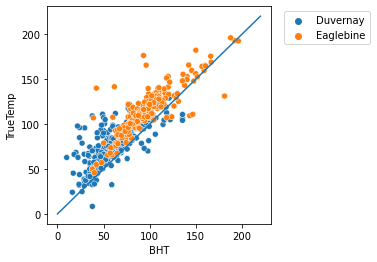

In [44]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=combined_temperature, 
                x="BHT",
                y="TrueTemp",
                hue='Field', ax=ax)

ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

## 4.1 TVD Vs Temperatures (Eaglebine & Duvernay Basins)

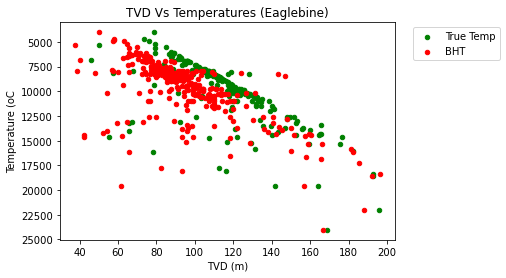

In [49]:
fig, ax1 = plt.subplots(sharex=True)
combined_temperature.plot.scatter(x='TrueTemp', y='TD (ft)', c='green', ax=ax1, label='True Temp')
combined_temperature.plot.scatter(x='BHT', y='TD (ft)', c='red', ax=ax1, label='BHT')
ax1.invert_yaxis()
ax1.set_xlabel('TVD (m)')
ax1.set_ylabel('Temperature (oC')
ax1.set_title('TVD Vs Temperatures (Eaglebine)')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

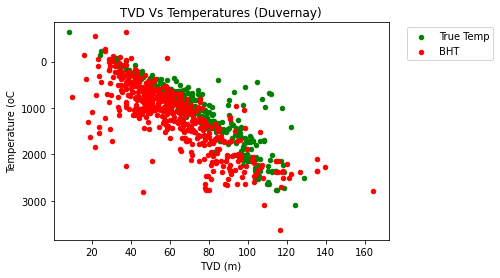

In [47]:
fig, ax2 = plt.subplots(sharex=True)
combined_temperature.plot.scatter(x='TrueTemp', y='Depth_SS(m)', c='green', ax=ax2, label='True Temp')
combined_temperature.plot.scatter(x='BHT', y='Depth_SS(m)', c='red', ax=ax2, label='BHT')
ax2.invert_yaxis()
ax2.set_xlabel('TVD (m)')
ax2.set_ylabel('Temperature (oC)')
ax2.set_title('TVD Vs Temperatures (Duvernay)')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

